In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import warnings
warnings.filterwarnings("ignore")

2025-11-09 13:37:41.290706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762695461.498243      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762695461.561071      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Задание 1: классификатор текстов романов

Обучили классификатор распознавать к какому из двух романов относится текст:

**Accuracy 0.77**

**F1 Macro 0.77**

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    return {"accuracy": accuracy, "f1_macro": f1_macro}

In [4]:
seed = 42
set_seed(seed)
df = pd.read_csv("/kaggle/input/textttt/train.csv", encoding='utf-8')
df['label'] = df['label'].astype(int)
df['text'] = df['text'].astype(str).str.replace("[—–−]","-",regex=True).str.replace(r"-{2,}","-",regex=True)

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['label'])

train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
valid_dataset = Dataset.from_pandas(valid_df[['text', 'label']].reset_index(drop=True))

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", use_fast=True)

def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding=False,
            truncation=True,
            max_length=tokenizer.model_max_length
        )



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(['text'])
valid_dataset = valid_dataset.remove_columns(['text'])

train_dataset.set_format('torch')
valid_dataset.set_format('torch')

model = AutoModelForSequenceClassification.from_pretrained(
        "distilroberta-base", num_labels=2)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/4512 [00:00<?, ? examples/s]

Map:   0%|          | 0/1128 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
training_args = TrainingArguments(
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    warmup_ratio=0.06, 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=16,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    seed=seed,
    fp16=torch.cuda.is_available(),
    report_to='none'
)

In [8]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

In [9]:
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"   
os.environ["WANDB_DISABLED"] = "true"            

trainer.train()

predictions = trainer.predict(valid_dataset)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.620400,0.613475,0.609627
2,No log,0.570545,0.698582,0.696382
3,No log,0.478802,0.735816,0.729968
4,0.580000,0.516095,0.715426,0.687171
5,0.580000,0.530673,0.752660,0.752627
6,0.580000,0.471368,0.771277,0.769316
7,0.580000,0.467911,0.766844,0.765635
8,0.414100,0.516910,0.763298,0.759321
9,0.414100,0.566186,0.762411,0.755771


Final Validation Metrics:
Accuracy: 0.7713
F1 Macro: 0.7693
Confusion Matrix:
[[383 150]
 [108 487]]


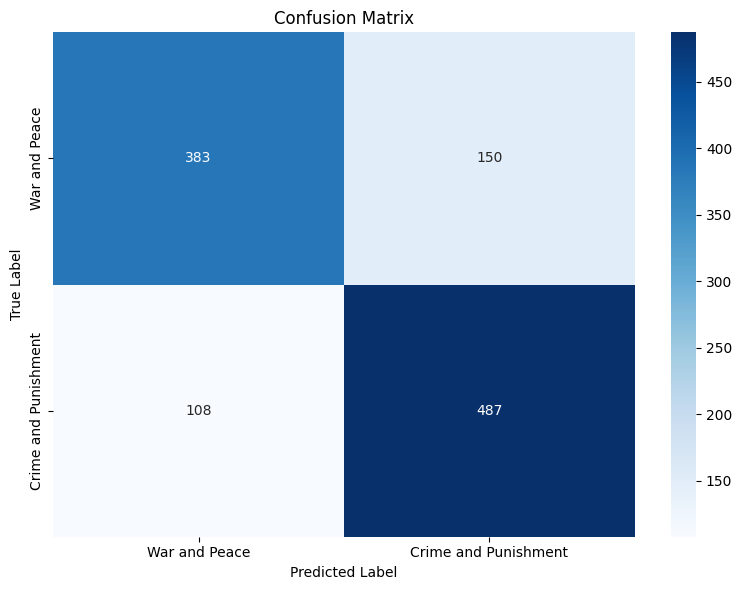

In [10]:
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"Final Validation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")

cm = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
          xticklabels=['War and Peace', 'Crime and Punishment'],
          yticklabels=['War and Peace', 'Crime and Punishment'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()

In [11]:
import json

metrics_dict = {
    'accuracy': float(accuracy),
    'f1_macro': float(f1_macro),
    'confusion_matrix': cm.tolist()
}

with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)

## Задание 2: unsupervised masked language modeling

Обучили модель восстанавливать замаскированный токен по окружающему контексту

In [12]:
import math

def compute_perplexity(eval_results):
    perplexity = math.exp(eval_results['eval_loss'])
    return perplexity

In [13]:
with open('/kaggle/input/textttt/mlm.txt', 'r', encoding='utf-8') as f:
    mlm_text = f.read()
mlm_lines = [line.strip() for line in mlm_text.split('\n') if line.strip()]
mlm_df = pd.DataFrame({'text': mlm_lines})
mlm_df['text'] = mlm_df['text'].astype(str).str.replace("[—–−]","-",regex=True).str.replace(r"-{2,}","-",regex=True)

mlm_dataset = Dataset.from_pandas(mlm_df)

In [14]:
def tokenize_function_mlm(examples):
    return tokenizer(
        examples['text'],
        padding=False,
        truncation=True,
        max_length=tokenizer.model_max_length
    )
    
mlm_dataset_tokenized = mlm_dataset.map(tokenize_function_mlm, batched=True, remove_columns=['text'])
mlm_dataset_tokenized.set_format('torch')
model_mlm = AutoModelForMaskedLM.from_pretrained("distilroberta-base")

data_collator_mlm = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
seed = 42
training_args_mlm = TrainingArguments(
    output_dir='./results_mlm',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    seed=seed,
    fp16=torch.cuda.is_available(),
    report_to='none'
)
trainer_mlm = Trainer(
    model=model_mlm,
    args=training_args_mlm,
    train_dataset=mlm_dataset_tokenized,
    eval_dataset=mlm_dataset_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator_mlm,
)

In [16]:
print("MLM model before pretraining:")
eval_results_before = trainer_mlm.evaluate()
perplexity_before = compute_perplexity(eval_results_before)
print(f"Loss before: {eval_results_before['eval_loss']:.4f}")
print(f"Perplexity before: {perplexity_before:.4f}")

trainer_mlm.train()

print("MLM model after pretraining:")
eval_results_after = trainer_mlm.evaluate()
perplexity_after = compute_perplexity(eval_results_after)
print(f"Loss after: {eval_results_after['eval_loss']:.4f}")
print(f"Perplexity after: {perplexity_after:.4f}")

MLM model before pretraining:


Loss before: 1.5069
Perplexity before: 4.5126


Epoch,Training Loss,Validation Loss
1,No log,1.502894
2,No log,1.756590
3,No log,1.798855


MLM model after pretraining:


Loss after: 1.3287
Perplexity after: 3.7760


In [17]:
model_mlm.save_pretrained('./pretrained_mlm')
tokenizer.save_pretrained('./pretrained_mlm')

('./pretrained_mlm/tokenizer_config.json',
 './pretrained_mlm/special_tokens_map.json',
 './pretrained_mlm/vocab.json',
 './pretrained_mlm/merges.txt',
 './pretrained_mlm/added_tokens.json',
 './pretrained_mlm/tokenizer.json')

## Задание 3: перетренировать классификатор

Использовали веса модели из предыдущего задания, чтобы дообучить классификатор текстов

In [18]:
model_cls_pretrained = AutoModelForSequenceClassification.from_pretrained(
    './pretrained_mlm',
    num_labels=2,
    ignore_mismatched_sizes=True
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrained_mlm and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
training_args_cls_pretrained = TrainingArguments(
    output_dir='./results_task3',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    lr_scheduler_type='cosine',
    warmup_ratio=0.06,
    label_smoothing_factor=0.05,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    save_total_limit=2,
    seed=seed,
    fp16=torch.cuda.is_available(),
    report_to='none')

trainer_cls_pretrained = Trainer(
    model=model_cls_pretrained,
    args=training_args_cls_pretrained,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer_cls_pretrained.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.617848,0.627660,0.620957
2,No log,0.582587,0.676418,0.671282
3,No log,0.535889,0.712766,0.712636
4,0.594200,0.547955,0.725177,0.705727
5,0.594200,0.559709,0.733156,0.732980
6,0.594200,0.504857,0.748227,0.744513
7,0.594200,0.520903,0.735816,0.725565
8,0.458000,0.543552,0.754433,0.751853
9,0.458000,0.580341,0.744681,0.734775
10,0.458000,0.598639,0.749113,0.745357


TrainOutput(global_step=1551, training_loss=0.4669214466323705, metrics={'train_runtime': 416.8569, 'train_samples_per_second': 216.477, 'train_steps_per_second': 6.765, 'total_flos': 687923899251648.0, 'train_loss': 0.4669214466323705, 'epoch': 11.0})

In [20]:
print("Evaluating pretrained classification model:")
eval_results_cls_pretrained = trainer_cls_pretrained.evaluate()
print(f"Pretrained Accuracy: {eval_results_cls_pretrained['eval_accuracy']:.4f}")
print(f"Pretrained F1: {eval_results_cls_pretrained['eval_f1_macro']:.4f}")

Evaluating pretrained classification model:


Pretrained Accuracy: 0.7544
Pretrained F1: 0.7519


In [23]:
test_df = pd.read_csv("/kaggle/input/textttt/submission_orig.csv", encoding='utf-8')

test_df['text'] = test_df['text'].fillna('').astype(str)
test_df['text'] = test_df['text'].astype(str).str.replace("[—–−]","-",regex=True).str.replace(r"-{2,}","-",regex=True)

test_dataset = Dataset.from_pandas(test_df[['text']].reset_index(drop=True))

test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset_tokenized.remove_columns(['text'])
test_dataset_tokenized.set_format('torch')

test_predictions_output = trainer_cls_pretrained.predict(test_dataset_tokenized)
test_predictions = np.argmax(test_predictions_output.predictions, axis=-1)

submission_df = pd.DataFrame({
    'text': test_df['text'],
    'label': test_predictions
})

submission_df.to_csv('submission_res.csv', index=False, encoding='utf-8')

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]